In [1]:
from IPython.display import display, HTML #make wider
display(HTML("<style>.container { width:100% !important; }</style>"))

import sys
sys.executable

'/home/zag/anaconda3/bin/python'

vmax : 977.7851717852076
rounded up : 1000
reload original lon_grid and lat_grid for quiver plot
reload original lon_grid and lat_grid for quiver plot


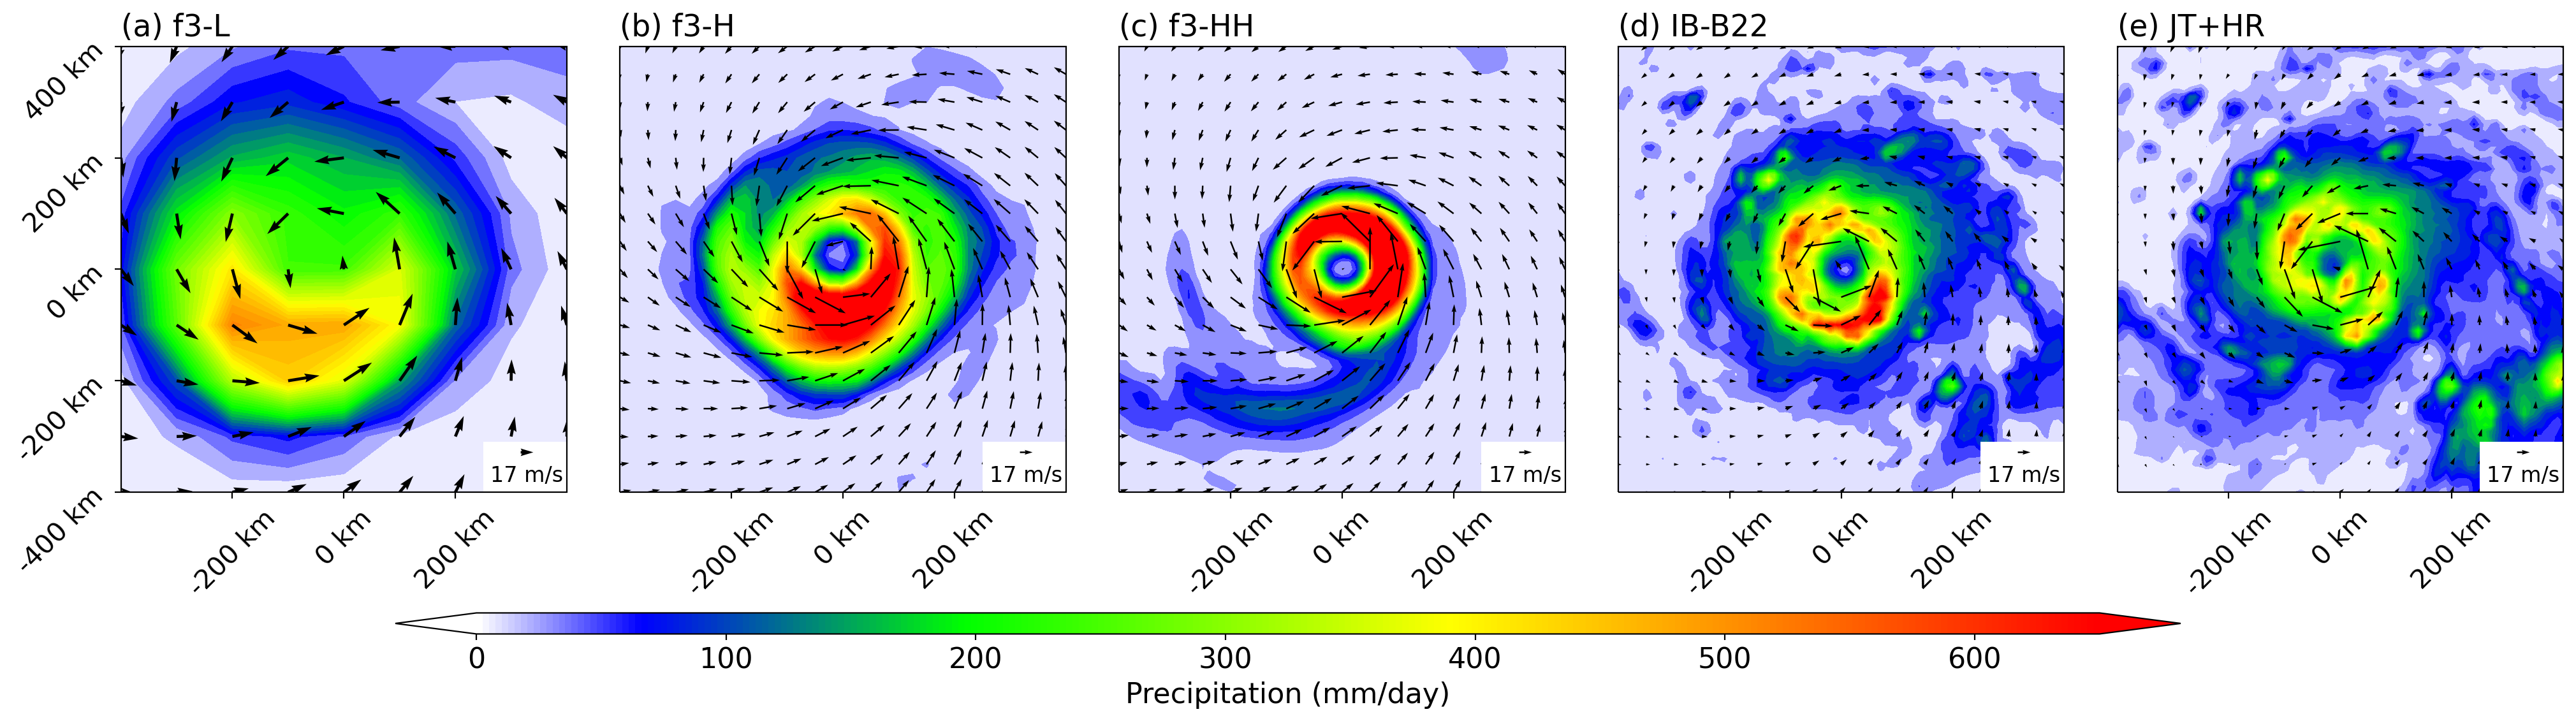

Exported combined plot to ../Data/Wind-Preci_composite


In [2]:
import math
import json
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import os
import matplotlib.colors as mcolors
from matplotlib.colors import Normalize
#import matplotlib.patches as patches
from matplotlib import patches
import matplotlib.lines as mlines

def round_up_to_nearest_tenth(value):
    return math.ceil(value * 10) / 10

def round_up_to_nearest_hundred(value):
    return math.ceil(value / 100) * 100

# Define a custom colormap
colors = [(1, 1, 1), (0, 0, 1), (0, 1, 0), (1, 1, 0), (1, 0, 0)]
nodes = [0.0, 0.1, 0.3, 0.6, 1.0]
custom_cmap = mcolors.LinearSegmentedColormap.from_list('custom_cmap', list(zip(nodes, colors)))

def plot_combined_data(wrk_path, spc_setup, sources, basin, plot_type, q_scale, labels, out_path):
    # Create figure with adjusted height to accommodate the single colorbar
    fig, axs = plt.subplots(1, 5, figsize=(20, 5.5), subplot_kw={'projection': ccrs.PlateCarree()})
    fig.set_dpi(200)

    all_vmax_values = []
    for ax, source in zip(axs, sources):
        if source == 'IB-B22M2  1d' or source == 'JT+HR-NR 1d':
            with open(os.path.join(wrk_path, f'{spc_setup}/{source}_{basin}_{period}_average_data.json'), 'r') as f:
                source_data = json.load(f)[source]
        else:
            with open(os.path.join(wrk_path, f'{source}_{basin}_{period}_average_data.json'), 'r') as f:
                source_data = json.load(f)[source]

        vmax = source_data['vmax']
        all_vmax_values.append(vmax)

    vmax = max(all_vmax_values)
    print(f'vmax : {vmax}')
    vmax = round_up_to_nearest_hundred(vmax)
    print(f'rounded up : {vmax}')
    vmin = 0
    vmax = 650
    
    norm = mcolors.Normalize(vmin=vmin, vmax=vmax) 
    sm = plt.cm.ScalarMappable(cmap=custom_cmap, norm=norm)
    sm.set_array([])

    # First pass: plot all the data
    for ax, source, label in zip(axs, sources, labels):
        if source == 'IB-B22M2  1d' or source == 'JT+HR-NR 1d':
            with open(os.path.join(wrk_path, f'{spc_setup}/{source}_{basin}_{period}_average_data.json'), 'r') as f:
                source_data = json.load(f)[source]
                p_c = source_data['p_count']
                u_c = source_data['u_count'] 
                v_c = source_data['v_count'] 
        else:
            with open(os.path.join(wrk_path, f'{source}_{basin}_{period}_average_data.json'), 'r') as f:
                source_data = json.load(f)[source]

        resolution = source_data['resolution']
        dist = source_data['dist']
        lat = np.array(source_data['lat'])
        lon = np.array(source_data['lon'])
        lon_grid = np.array(source_data['lon_grid'])
        lat_grid = np.array(source_data['lat_grid'])
        precip = np.array(source_data['precip'])
        u_wind = np.array(source_data['u_wind'])
        v_wind = np.array(source_data['v_wind'])

        extent = [lon.min(), lon.max(), lat.min(), lat.max()]

        ######### Here is for Precip #############################################################
        if source == 'IB-B22M2  1d' or source == 'JT+HR-NR 1d':
            resolution = 0.1 # this is for GPM v07 precipitation data
            lat = np.linspace(-dist, dist, 2*int(dist/resolution)+1)
            lon = np.linspace(-dist, dist, 2*int(dist/resolution)+1)

            lon_grid, lat_grid = np.meshgrid(lon, lat)
            extent = [lon.min(), lon.max(), lat.min(), lat.max()]

        if plot_type == 'contour':
            im = ax.contourf(lon_grid, lat_grid, precip, levels=50, cmap=custom_cmap, norm=norm, transform=ccrs.PlateCarree())
        elif plot_type == 'heatmap':
            im = ax.imshow(precip, cmap='Blues', origin='lower', extent=extent, norm=norm, transform=ccrs.PlateCarree())

        ######### Now WIND field #################################################################
        if source == 'IB-B22M2  1d' or source == 'JT+HR-NR 1d':
            print('reload original lon_grid and lat_grid for quiver plot')
            # this is for ERA5 wind data
            lon_grid = np.array(source_data['lon_grid'])
            lat_grid = np.array(source_data['lat_grid'])

            # Resample the wind data for plotting quivers
            quiver_step = 2
            lon_grid_resampled = lon_grid[::quiver_step, ::quiver_step]
            lat_grid_resampled = lat_grid[::quiver_step, ::quiver_step]
            u_wind_resampled = u_wind[::quiver_step, ::quiver_step]
            v_wind_resampled = v_wind[::quiver_step, ::quiver_step]

            q = ax.quiver(lon_grid_resampled, lat_grid_resampled, u_wind_resampled, v_wind_resampled, scale=q_scale, transform=ccrs.PlateCarree())

        elif source == 'f3-H':
            quiver_step = 2
            # Resample the wind data for plotting quivers
            lon_grid_resampled = lon_grid[::quiver_step, ::quiver_step]
            lat_grid_resampled = lat_grid[::quiver_step, ::quiver_step]
            u_wind_resampled = u_wind[::quiver_step, ::quiver_step]
            v_wind_resampled = v_wind[::quiver_step, ::quiver_step]

            q = ax.quiver(lon_grid_resampled, lat_grid_resampled, u_wind_resampled, v_wind_resampled, scale=q_scale, transform=ccrs.PlateCarree())

        elif source == 'f3-HH':
            quiver_step = 4
            # Resample the wind data for plotting quivers
            lon_grid_resampled = lon_grid[::quiver_step, ::quiver_step]
            lat_grid_resampled = lat_grid[::quiver_step, ::quiver_step]
            u_wind_resampled = u_wind[::quiver_step, ::quiver_step]
            v_wind_resampled = v_wind[::quiver_step, ::quiver_step]

            q = ax.quiver(lon_grid_resampled, lat_grid_resampled, u_wind_resampled, v_wind_resampled, scale=q_scale, transform=ccrs.PlateCarree())

        else:
            # this is for f3-L as it comes with 1 degree by default
            q = ax.quiver(lon_grid, lat_grid, u_wind, v_wind, scale=q_scale, transform=ccrs.PlateCarree())

        box_x, box_y = 2.5, -4.0
        box_width, box_height = 1.5, 0.9
        rect = patches.Rectangle((box_x,box_y), box_width, box_height, facecolor='white', transform=ccrs.PlateCarree(), edgecolor='none', alpha=1, zorder=1)
        ax.add_patch(rect)
        ax.quiverkey(q, 0.91, 0.09, 17, '17 m/s', color='k', labelpos='S', facecolor='black', fontproperties={'size':12})

        ax.set_xlim(-dist, dist)
        ax.set_ylim(-dist, dist)
        
        ax.set_xticks(np.arange(-dist +2, dist+1 -2, 2))
        ax.set_xticklabels([f'{i*100} km' for i in np.arange(-dist +2, dist+1 -2, 2)], rotation=45, fontsize=15)
        
        if ax == axs[0]:  # Check if this is the first subplot
            ax.set_yticks(np.arange(-dist, dist+1, 2))
            ax.set_yticklabels([f'{i*100} km' for i in np.arange(-dist, dist+1, 2)], rotation=45, zorder=10, fontsize=15)

        ax.set_title(f'{label} ', loc='left', fontsize=17)

        # REMOVED: Individual colorbar creation for each subplot

    # ADD SINGLE COLORBAR WITH EXACT POSITION CONTROL
    plt.tight_layout(pad=0, h_pad=0, w_pad=3)
    plt.subplots_adjust(bottom=0.2)  # More space at bottom
    
    # Manually position the colorbar
    cbar_ax = fig.add_axes([0.15, 0.08, 0.7, 0.03])  # [left, bottom, width, height]
    cbar = fig.colorbar(sm, cax=cbar_ax, orientation='horizontal', extend='both')
    cbar.set_label('Precipitation (mm/day)', fontsize=16)
    cbar.ax.tick_params(labelsize=16)  # Add this line for tick label font size
    
    output_filename = os.path.join(out_path, f'10_Composite of Precipitation and Wind-GFS.pdf')
    plt.savefig(output_filename, dpi=600, bbox_inches='tight', format='pdf')
    plt.show() # When Using JUPYTER NOTEBOOK
    plt.close()
    print(f"Exported combined plot to {wrk_path}")

# Your existing configuration
spc_setup = 'IRP_6hResampling_JP_GFS_03-03'
basin = 'NH'
period = '200006-200712'
wrk_path = '../Data/Wind-Preci_composite'
out_path = '../Figure'
sources = ['f3-L', 'f3-H', 'f3-HH', 'IB-B22M2  1d', 'JT+HR-NR 1d']
plot_type = 'contour'
q_scale = 600
labels = ['(a) f3-L', '(b) f3-H', '(c) f3-HH', '(d) IB-B22', '(e) JT+HR']

# Example usage:
plot_combined_data(wrk_path, spc_setup, sources, basin, plot_type, q_scale, labels, out_path)